# HASY dataset visualization

In [1]:
import sys
sys.path.append('/home/jovyan/work/databases/HASY/')
from hasy_tools_updated import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.ndimage
from PIL import Image, ImageDraw
import csv
import os
import random
import pickle

`hasy-data`: 168236 png images, each 32px x 32px 

`hasy-data-labels.csv`: Labels for all images.

## Hasy_tools.py functions

From the `hasy` package in https://github.com/MartinThoma/HASY

In [373]:
def load_csv(filepath, delimiter=',', quotechar="'"):
    """
    Load a CSV file.

    Parameters
    ----------
    filepath : str
        Path to a CSV file
    delimiter : str, optional
    quotechar : str, optional

    Returns
    -------
    list of dicts : Each line of the CSV file is one element of the list.
    """
    data = []
    csv_dir = os.path.dirname(filepath)
    with open(filepath, 'rt') as csvfile:
        reader = csv.DictReader(csvfile,
                                delimiter=delimiter,
                                quotechar=quotechar)
        for row in reader:
            if 'path' in row:
                row['path'] = os.path.abspath(os.path.join(csv_dir,
                                                           row['path']))
            data.append(row)
    return data

def load_images(csv_filepath, symbol_id2index, one_hot=True, flatten=False):
    """
    Load the images into a 4D uint8 numpy array [index, y, x, depth].

    Parameters
    ----------
    csv_filepath : str
        'test.csv' or 'train.csv'
    symbol_id2index : dict
        Dictionary generated by generate_index
    one_hot : bool, optional
        Make label vector as 1-hot encoding, otherwise index
    flatten : bool, optional
        Flatten feature vector

    Returns
    -------
    images, labels : Images is a 4D uint8 numpy array [index, y, x, depth]
                     and labels is a 2D uint8 numpy array [index][1-hot enc].
    """
    WIDTH, HEIGHT = 32, 32
    dataset_path = os.path.dirname(csv_filepath)  # Main directory of HASY
    data = load_csv(csv_filepath)
    if flatten:
        images = np.zeros((len(data), WIDTH * HEIGHT))
    else:
        images = np.zeros((len(data), WIDTH, HEIGHT, 1))
        #print(np.shape(images)) -> (168233, 32, 32, 1)
    labels = []
    for i, data_item in enumerate(data):
        fname = os.path.join(dataset_path, data_item['path'])
        # img = Image.open(fname).convert('L')
        #print(np.shape(np.asarray(img))) -> (32, 32)

        if flatten:
            img = Image.open(fname).convert('L')
            images[i, :] = np.asarray(img).flatten()
        else:
            img = Image.open(fname).convert('L')
            images[i, :, :, 0] = np.asarray(img)
            
        label = symbol_id2index[data_item['symbol_id']]
        labels.append(label)
    data = images, np.array(labels)
    if one_hot:
        data = (data[0], np.eye(len(symbol_id2index))[data[1]])
    return data


def create_random_overview(img_src, x_images, y_images):
    """Create a random overview of images."""
    # Create canvas
    background = Image.new('RGB',
                           (35 * x_images, 35 * y_images),
                           (255, 255, 255))
    bg_w, bg_h = background.size
    # Paste image on canvas
    for x in range(x_images):
        for y in range(y_images):
            path = random.choice(img_src)['path']
            img = Image.open(path, 'r')
            img_w, img_h = img.size
            offset = (35 * x, 35 * y)
            background.paste(img, offset)
    # Draw lines
    draw = ImageDraw.Draw(background)
    for y in range(y_images):  # horizontal lines
        draw.line((0, 35 * y - 2, 35 * x_images, 35 * y - 2), fill='gray')
    for x in range(x_images):  # vertical lines
        draw.line((35 * x - 2, 0, 35 * x - 2, 35 * y_images), fill='gray')
    # Write fill=0 for black lines    
    
    display(background)
    # Store
    background.save('hasy-overview_1.png')


def get_symbolid2latex(csv_filepath='symbols.csv'):
    """Return a dict mapping symbol_ids to LaTeX code."""
    symbol_data = load_csv(csv_filepath)
    symbolid2latex = {}
    for row in symbol_data:
        symbolid2latex[row['symbol_id']] = row['latex']
    return symbolid2latex

def generate_index(csv_filepath):
    """
    Generate an index 0...k for the k labels.

    Parameters
    ----------
    csv_filepath : str
        Path to 'test.csv' or 'train.csv'

    Returns
    -------
    dict : Maps a symbol_id as in test.csv and
        train.csv to an integer in 0...k, where k is the total
        number of unique labels.
    """
    symbol_id2index = {}
    data = load_csv(csv_filepath)
    i = 0
    for item in data:
        if item['symbol_id'] not in symbol_id2index:
            symbol_id2index[item['symbol_id']] = i
            i += 1
    return symbol_id2index

def _analyze_class_distribution(csv_filepath,
                                max_data=1000,
                                bin_size=25):
    """Plot the distribution of training data over graphs."""
    symbol_id2index = generate_index(csv_filepath)
    index2symbol_id = {}
    for index, symbol_id in symbol_id2index.items():
        index2symbol_id[symbol_id] = index
    data, y = load_images(csv_filepath, symbol_id2index, one_hot=False)

    data = {}
    for el in y:
        if el in data:
            data[el] += 1
        else:
            data[el] = 1
    classes = data
    images = len(y)

    # Create plot
    print("Classes: %i" % len(classes))
    print("Images: %i" % images)

    class_counts = sorted([count for _, count in classes.items()])
    print("\tmin: %i" % min(class_counts))

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    # plt.title('HASY training data distribution')
    plt.xlabel('Amount of available testing images')
    plt.ylabel('Number of classes')

    # Where we want the ticks, in pixel locations
    ticks = [int(el) for el in list(np.linspace(0, 200, 21))]
    # What those pixel locations correspond to in data coordinates.
    # Also set the float format here
    ax1.set_xticks(ticks)
    labels = ax1.get_xticklabels()
    plt.setp(labels, rotation=30)

    min_examples = 0
    ax1.hist(class_counts, bins=range(min_examples, max_data + 1, bin_size))
    # plt.show()
    filename = '{}.pdf'.format('data-dist')
    plt.savefig(filename)
    print("Plot has been saved as {}".format(filename))

    symbolid2latex = get_symbolid2latex()

    top10 = sorted(classes.items(), key=lambda n: n[1], reverse=True)[:10]
    top10_data = 0
    for index, count in top10:
        print("\t%s:\t%i" % (symbolid2latex[index2symbol_id[index]], count))
        top10_data += count
    total_data = sum([count for index, count in classes.items()])
    print("Top-10 has %i training data (%0.2f%% of total)" %
          (top10_data, float(top10_data) * 100.0 / total_data))
    print("%i classes have more than %i data items." %
          (sum([1 for _, count in classes.items() if count > max_data]),
           max_data))
    print(top10)


def _analyze_correlation(csv_filepath):
    """
    Analyze and visualize the correlation of features.
    Takes 1.5h.

    Parameters
    ----------
    csv_filepath : str
        Path to a CSV file which points to images
    """
    import pandas as pd
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    symbol_id2index = generate_index(csv_filepath)
    data, y = load_images(csv_filepath,
                          symbol_id2index,
                          one_hot=False,
                          flatten=True)
    df = pd.DataFrame(data=data)

    print("Data loaded. Start correlation calculation. Takes 1.5h.")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # Where we want the ticks, in pixel locations
    ticks = np.linspace(0, 1024, 17)
    # What those pixel locations correspond to in data coordinates.
    # Also set the float format here
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    labels = ax1.get_xticklabels()
    plt.setp(labels, rotation=30)

    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    # Add colorbar, make sure to specify tick locations to match desired
    # ticklabels
    fig.colorbar(cax, ticks=[-0.15, 0, 0.15, 0.30, 0.45, 0.60, 0.75, 0.90, 1])
    filename = '{}.pdf'.format('feature-correlation')
    plt.savefig(filename)

def data_by_class(data):
    """
    Organize `data` by class.

    Parameters
    ----------
    data : list of dicts
        Each dict contains the key `symbol_id` which is the class label.

    Returns
    -------
    dbc : dict
        mapping class labels to lists of dicts
    """
    dbc = {}
    for item in data:
        if item['symbol_id'] in dbc:
            dbc[item['symbol_id']].append(item)
        else:
            dbc[item['symbol_id']] = [item]
    return dbc

def _is_valid_png(filepath):
    """
    Check if the PNG image is valid.

    Parameters
    ----------
    filepath : str
        Path to a PNG image

    Returns
    -------
    bool : True if the PNG image is valid, otherwise False.
    """
    try:
        test = Image.open(filepath)
        test.close()
        return True
    except:
        return False

def _verify_all():
    """Verify all PNG files in the training and test directories."""
    for csv_data_path in ['classification-task/fold-1/test.csv',
                          'classification-task/fold-1/train.csv']:
        train_data = load_csv(csv_data_path)
        for data_item in train_data:
            if not _is_valid_png(data_item['path']):
                logging.info("%s is invalid." % data_item['path'])
        print("Checked %i items of %s." %
                     (len(train_data), csv_data_path))
        
#_verify_all()

In [297]:
16992+151241

168233

In [371]:
def create_stratified_split(csv_filepath='benat-data/train.csv', n_splits=5, kdirectory='benat-data/cv'):
    """
    Create a stratified split for the classification task.

    Parameters
    ----------
    csv_filepath : str
        Path to a CSV file which points to images
    n_splits : int
        Number of splits to make
    kdirectory : str
        Path to a directory where the output cvs-s will ve saved
    """
    from sklearn.model_selection import StratifiedKFold
    data = load_csv(csv_filepath)
    labels = [el['symbol_id'] for el in data]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    i = 1
    # kdirectory = 'classification-task'
    if not os.path.exists(kdirectory):
            os.makedirs(kdirectory)
    for train_index, test_index in skf.split(np.zeros(len(labels)), labels):
        # Note that providing labels (y) is sufficient to generate the splits and hence np.zeros(n_samples) may be used as a placeholder for X instead of actual training data.
        print("Create fold %i" % i)
        directory = "%s/fold-%i" % (kdirectory, i)
        if not os.path.exists(directory):
            os.makedirs(directory)
        else:
            print("Directory '%s' already exists. Please remove it." %
                  directory)
        i += 1
        train = [data[el] for el in train_index]
        test_ = [data[el] for el in test_index]
        for dataset, name in [(train, 'train'), (test_, 'test')]:
            with open(f"{directory}/{name}.csv", 'wt') as csv_file:
                csv_writer = csv.writer(csv_file)
                csv_writer.writerow(('path', 'symbol_id', 'latex', 'user_id'))
                for el in dataset:
                    csv_writer.writerow((el['path'],
                                         el['symbol_id'],
                                         el['latex'],
                                         el['user_id']))



def create_stratified_train_test(csv_filepath, kdirectory='benat-data'):
    """
    Create a stratified split for the classification task.
    Modified version of create_stratified_split(), by Beñat Berasategui.

    Parameters
    ----------
    csv_filepath : str
        Path to a CSV file which points to images
    kdirectory : str
        Path to a directory where the output cvs-s will ve saved
    """
    from sklearn.model_selection import StratifiedShuffleSplit
    data = load_csv(csv_filepath)
    labels = [el['symbol_id'] for el in data]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
    i = 1
    # kdirectory = 'classification-task'
    if not os.path.exists(kdirectory):
            os.makedirs(kdirectory)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels): 
        # Note that providing labels (y) is sufficient to generate the splits and hence np.zeros(n_samples) may be used as a placeholder for X instead of actual training data.
        print("Create fold %i" % i)
        #directory = "%s/fold-%i" % (kdirectory, i)
        #if not os.path.exists(directory):
        #    os.makedirs(directory)
        #else:
        #    print("Directory '%s' already exists. Please remove it." %
        #          directory)
        i += 1
        train = [data[el] for el in train_index]
        test_ = [data[el] for el in test_index]
        for dataset, name in [(train, 'train'), (test_, 'test')]:
            with open(kdirectory+f"/{name}.csv", 'wt') as csv_file:
                csv_writer = csv.writer(csv_file)
                csv_writer.writerow(('path', 'symbol_id', 'latex', 'user_id'))
                for el in dataset:
                    csv_writer.writerow((el['path'],
                                         el['symbol_id'],
                                         el['latex'],
                                         el['user_id']))



## Comprobaciones de que las etiquetas y las imágenes (y, X) se corresponden

In [25]:
_csv_filepath='/home/jovyan/work/databases/HASY/benat-data/cv/fold-1/test.csv'
_symbol_id2index = generate_index(_csv_filepath)
_index2symbol_id = {}
for index, symbol_id in _symbol_id2index.items():
    _index2symbol_id[symbol_id] = index
X_test, y_test = load_images(_csv_filepath, _symbol_id2index, one_hot=False, flatten = True)



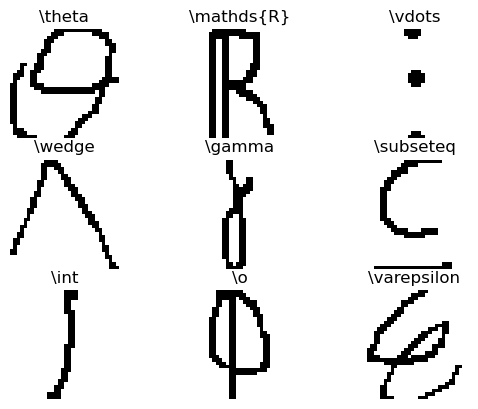

In [29]:
image = X_test
#rndm_elements = random.sample(range(len(y_test)),9)
a = 9
rndm_elements = list(range(a,a+9))

for i,img in enumerate(rndm_elements,1):
    plt.subplot(330+i)
    plt.axis("off")
    #plt.title("Label: {}".format(y[img]))
    plt.title(f"{symbolid2latex[_index2symbol_id[y_test[img]]]}")
    plt.imshow((X_test[img].reshape(32,32)), cmap='gray', interpolation='nearest')

## Load and process a csv file

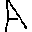

In [22]:
test = Image.open('hasy-data/v2-00000.png')
#test.save('proba.png', "png")
display(test)

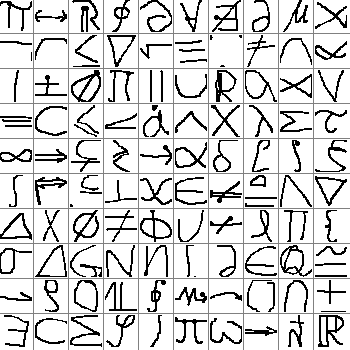

In [47]:
img_src = load_csv('./hasy-data-labels.csv')
create_random_overview(img_src, x_images=10, y_images=10)

Classes: 369
Images: 168233
	min: 51
Plot has been saved as data-dist.pdf
	\int:	3514
	\sum:	3400
	\infty:	2914
	\alpha:	2601
	\xi:	2567
	\equiv:	2518
	\partial:	2413
	\mathds{R}:	2378
	\in:	2296
	\square:	2179
Top-10 has 26780 training data (15.92% of total)
203 classes have more than 200 data items.
[(100, 3514), (40, 3400), (279, 2914), (38, 2601), (85, 2567), (172, 2518), (99, 2413), (331, 2378), (255, 2296), (294, 2179)]


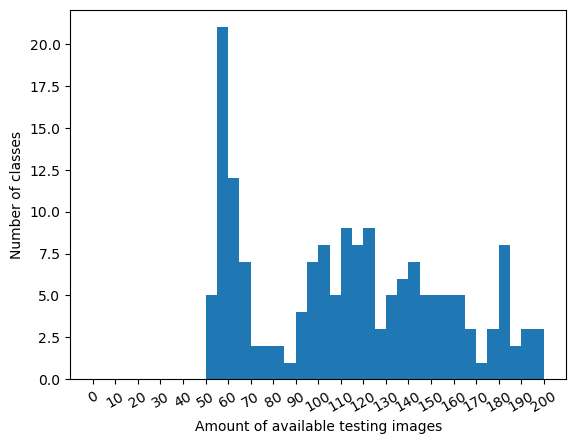

In [97]:
_analyze_class_distribution(csv_filepath='./hasy-data-labels.csv',
                                    max_data=200,
                                    bin_size=5)

Comparación con el training test de `benat-data/test.csv` a continuación.

Classes: 369
Images: 134586
	min: 41
Plot has been saved as data-dist.pdf
	\int:	2811
	\sum:	2720
	\infty:	2331
	\alpha:	2081
	\xi:	2053
	\equiv:	2014
	\partial:	1930
	\mathds{R}:	1902
	\in:	1837
	\square:	1743
Top-10 has 21422 training data (15.92% of total)
169 classes have more than 200 data items.
[(49, 2811), (15, 2720), (17, 2331), (55, 2081), (44, 2053), (6, 2014), (59, 1930), (68, 1902), (98, 1837), (72, 1743)]


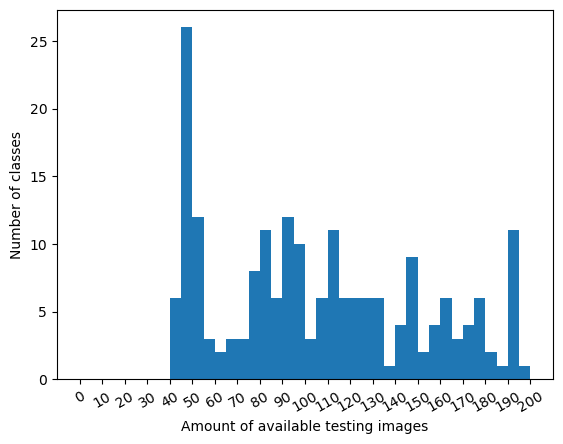

In [372]:
_analyze_class_distribution(csv_filepath='./benat-data/train.csv',
                                    max_data=200,
                                    bin_size=5)

Data loaded. Start correlation calculation. Takes 1.5h.


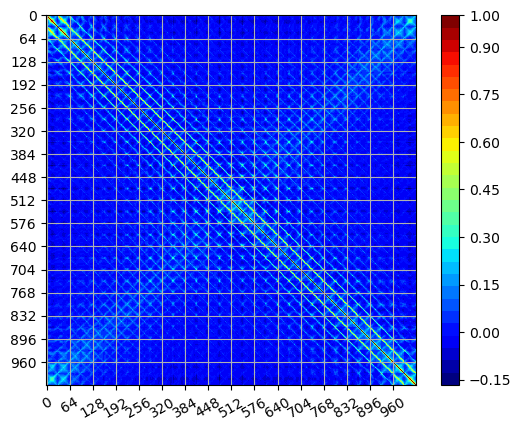

In [101]:
# This Takes 1.5h
_analyze_correlation(csv_filepath='./hasy-data-labels.csv')

In [184]:
# Cuantos datos hay por clase?
data_dict = load_csv(csv_filepath)
data_dict = data_by_class(data_dict)

In [186]:
dict(list(data_dict.items())[0:2])

{'31': [{'path': '/home/jovyan/work/databases/HASY/hasy-data/v2-00000.png',
   'symbol_id': '31',
   'latex': 'A',
   'user_id': '50'},
  {'path': '/home/jovyan/work/databases/HASY/hasy-data/v2-00001.png',
   'symbol_id': '31',
   'latex': 'A',
   'user_id': '10'},
  {'path': '/home/jovyan/work/databases/HASY/hasy-data/v2-00002.png',
   'symbol_id': '31',
   'latex': 'A',
   'user_id': '43'},
  {'path': '/home/jovyan/work/databases/HASY/hasy-data/v2-00003.png',
   'symbol_id': '31',
   'latex': 'A',
   'user_id': '43'},
  {'path': '/home/jovyan/work/databases/HASY/hasy-data/v2-00004.png',
   'symbol_id': '31',
   'latex': 'A',
   'user_id': '4435'},
  {'path': '/home/jovyan/work/databases/HASY/hasy-data/v2-00005.png',
   'symbol_id': '31',
   'latex': 'A',
   'user_id': '5981'},
  {'path': '/home/jovyan/work/databases/HASY/hasy-data/v2-00006.png',
   'symbol_id': '31',
   'latex': 'A',
   'user_id': '5981'},
  {'path': '/home/jovyan/work/databases/HASY/hasy-data/v2-00007.png',
   'symb

In [109]:
data.keys()

dict_keys(['31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '59', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '81', '82', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '110', '111', '112', '113', '114', '115', '116', '117', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '254', '257', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '508', '510', '511', '512', '513', '514', '517', '520', '521', '523', '524', '526', '527', '528', '529', '530', '531', '532', '533', '534', '535'

In [115]:
#data['179']

In [3]:
csv_filepath='./hasy-data-labels.csv'
symbol_id2index = generate_index(csv_filepath)
index2symbol_id = {}
for index, symbol_id in symbol_id2index.items():
    index2symbol_id[symbol_id] = index
data, y = load_images(csv_filepath, symbol_id2index, one_hot=False, flatten = True)

In [10]:
symbolid2latex = get_symbolid2latex()
symbolid2latex[index2symbol_id[0]]

'A'

In [135]:
#plt.imsave('proba.png',data[0])
im = Image.fromarray(np.uint8(data[0]),mode='L')
im.save("img1.png")

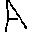

In [140]:
rescaled = (255.0 / data[0].max() * (data[0] - data[0].min())).astype(np.uint8)

rescaled = np.reshape(rescaled, (32, 32)) 
im = Image.fromarray(rescaled)
im.save('test.png')

im

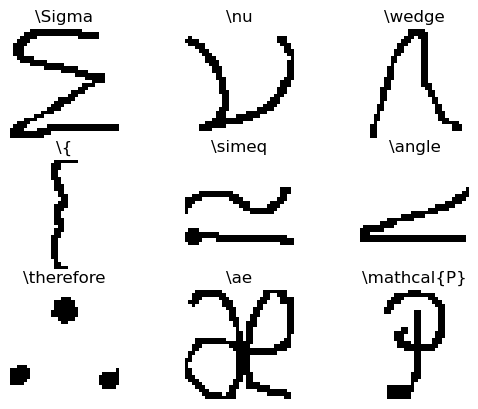

In [24]:
#image=(255.0 / data.max() * (data - data.min())).astype(np.uint8)
image = data

rndm_elements = random.sample(range(len(y)),9)

for i,img in enumerate(rndm_elements,1):
    plt.subplot(330+i)
    plt.axis("off")
    #plt.title("Label: {}".format(y[img]))
    plt.title(f"{symbolid2latex[index2symbol_id[y[img]]]}")
    plt.imshow((image[img].reshape(32,32)), cmap='gray', interpolation='nearest')
    

## Attemp to create a personalized dataset

Each item will have `32x32=1024` features.

In [148]:
X = pd.DataFrame(data)
Y = pd.DataFrame(y)

In [151]:
X.shape, Y.shape

((168233, 1024), (168233, 1))

In [153]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,255.0,255.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0,0.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,0.0,0.0,255.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,0.0,0.0,0.0,255.0,255.0,255.0
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,0.0,0.0,255.0,255.0,255.0,255.0


In [158]:
Y.head()

,0
0,0
1,0
2,0
3,0
4,0


In [160]:
Y.tail()

,0
168228,368
168229,368
168230,368
168231,368
168232,368


In [191]:
dict(list(index2symbol_id.items())[90:100])

{90: '171',
 91: '174',
 92: '175',
 93: '176',
 94: '177',
 95: '178',
 96: '179',
 97: '180',
 98: '181',
 99: '182'}

In [175]:
# Number of different symbols (indexes)
len(index2symbol_id)

369

Ahora necesitamos una manera de traducir estos IDs de los símbolos a los códigos de $\LaTeX$. Existe ya una función!

In [189]:
symbolid2latex = get_symbolid2latex()
len(symbolid2latex)

369

In [192]:
dict(list(symbolid2latex.items())[90:100])

{'171': '\\tau',
 '174': '\\phi',
 '175': '\\Phi',
 '176': '\\varphi',
 '177': '\\chi',
 '178': '\\psi',
 '179': '\\Psi',
 '180': '\\omega',
 '181': '\\Omega',
 '182': '\\partial'}

En los dataframes `X` e `Y` tenemos **índices** de 0 a 168232. Me parece que existe la opción de etiquetarlos con el código de Gray, para que no exista una relación ordinal. Estos índices se traducen a **IDs de los símbolos** mediante la función `symbol_id2index`, cuyo resultado se invierte de la siguiente manera para obtener el diccionario `index2symbol_id`:
```
symbol_id2index = generate_index(csv_filepath)
index2symbol_id = {}
for index, symbol_id in symbol_id2index.items():
    index2symbol_id[symbol_id] = index
    
```
Por último, estos se pueden relacionar con el **comando** de $\LaTeX$ correspondiente utilizando `get_symbolid2latex()`.

## División de los datos utilizando la función `create_stratified_train_test`

Además de esto, creo un nuevo módulo `hasy_tools_updated`con las funciones que he revisado.

In [330]:
create_stratified_train_test('hasy-data-labels.csv', kdirectory='benat-data')

Create fold 1


In [337]:
test_set = load_csv('benat-data/test.csv')
train_set = load_csv('benat-data/train.csv')

perc_test = len(test_set)/(len(test_set)+len(train_set))*100
perc_train = len(train_set)/(len(test_set)+len(train_set))*100

print(f"Train: %{perc_train:.2f}, test: %{perc_test:.2f}")

Train: %80.00, test: %20.00


In [350]:
csv_filepath='./benat-data/train.csv'
symbol_id2index = generate_index(csv_filepath)
index2symbol_id = {}
for index, symbol_id in symbol_id2index.items():
    index2symbol_id[symbol_id] = index
data, y = load_images(csv_filepath, symbol_id2index, one_hot=False, flatten = True)

In [351]:
X = pd.DataFrame(data)
Y = pd.DataFrame(y)

In [352]:
X.shape, Y.shape

((134586, 1024), (134586, 1))

In [354]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0,...,255.0,255.0,255.0,255.0,0.0,0.0,0.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4,255.0,255.0,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [355]:
Y.head()

,0
0,0
1,1
2,2
3,3
4,4


In [356]:
Y.tail()

,0
134581,13
134582,73
134583,139
134584,17
134585,291


In [357]:
dict(list(index2symbol_id.items())[90:100])

{90: '711',
 91: '163',
 92: '1007',
 93: '1382',
 94: '917',
 95: '169',
 96: '115',
 97: '41',
 98: '888',
 99: '161'}

In [358]:
# Number of different symbols (indexes)
len(index2symbol_id)

369

Ahora necesitamos una manera de traducir estos IDs de los símbolos a los códigos de $\LaTeX$. Existe ya una función!

In [359]:
symbolid2latex = get_symbolid2latex()
len(symbolid2latex)

369

In [361]:
dict(list(symbolid2latex.items())[90:100])

{'171': '\\tau',
 '174': '\\phi',
 '175': '\\Phi',
 '176': '\\varphi',
 '177': '\\chi',
 '178': '\\psi',
 '179': '\\Psi',
 '180': '\\omega',
 '181': '\\Omega',
 '182': '\\partial'}

### Conjuntos de cross-validation

De paso, voy a crear 5 conjuntos de cross-validation, para utilizarlos en caso que sea necesario.

In [346]:
create_stratified_split(n_splits=5)

Create fold 1
Directory 'benat-data/cv/fold-1' already exists. Please remove it.
Create fold 2
Directory 'benat-data/cv/fold-2' already exists. Please remove it.
Create fold 3
Directory 'benat-data/cv/fold-3' already exists. Please remove it.
Create fold 4
Directory 'benat-data/cv/fold-4' already exists. Please remove it.
Create fold 5
Directory 'benat-data/cv/fold-5' already exists. Please remove it.


In [349]:
test_set = load_csv('benat-data/cv/fold-1/test.csv')
train_set = load_csv('benat-data/cv/fold-1/train.csv')

perc_test = len(test_set)/(len(test_set)+len(train_set))*100
perc_train = len(train_set)/(len(test_set)+len(train_set))*100

print(f"Train: %{perc_train:.2f}, test: %{perc_test:.2f}")

Train: %80.00, test: %20.00


### Guardar datos como dataframes de pandas

In [7]:
#X_train, X_test, y_train, y_test
X_train, y_train, symbol_id2index_train, index2symbol_id_train = load_database('/home/jovyan/work/databases/HASY/benat-data/train.csv')
X_test, y_test, symbol_id2index_test, index2symbol_id_test = load_database('/home/jovyan/work/databases/HASY/benat-data/test.csv')

In [9]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [34]:
X_train.to_csv('benat-data/pandas_df/X_train.csv')
#y_train.to_csv('benat-data/pandas_df/y_train.csv')
X_test.to_csv('benat-data/pandas_df/X_test.csv')
#y_test.to_csv('benat-data/pandas_df/y_test.csv')

In [16]:
list_of_dicts = [symbol_id2index_train, index2symbol_id_train, symbol_id2index_test, index2symbol_id_test]

with open('benat-data/pandas_df/dict_list.pkl', 'wb') as f:
    pickle.dump(list_of_dicts, f)

In [18]:
with open('benat-data/pandas_df/dict_list.pkl', 'rb') as f:
    loaded_list_of_dicts = pickle.load(f)

len(loaded_list_of_dicts)

4

In [29]:
X_test_load = pd.read_csv('benat-data/pandas_df/X_test.csv', index_col=0)

In [38]:
help(hasy_tools_updated)

Help on module hasy_tools_updated:

NAME
    hasy_tools_updated - Tools for the HASY dataset.

DESCRIPTION
    Original file: https://github.com/MartinThoma/HASY/blob/master/hasy/hasy_tools.py
    Or: https://pypi.org/project/hasy/
    
    Some changes where made by Beñat Berasategui to update the obsolete code.
    
    To access this module:
    import sys
    sys.path.append('work/databases/HASY/')

FUNCTIONS
    create_random_overview(img_src, x_images, y_images)
        Create a random overview of images.
    
    create_stratified_split(csv_filepath='benat-data/train.csv', n_splits=5, kdirectory='benat-data/cv')
        Create a stratified split for the classification task.
        
        Parameters
        ----------
        csv_filepath : str
            Path to a CSV file which points to images
        n_splits : int
            Number of splits to make
        kdirectory : str
            Path to a directory where the output cvs-s will ve saved
    
    create_stratified_t

## Pruebas

Examinar bien las carpetas proporcionadas en el repositorio del DataSet. Me conviene aprovechar esas, o es mejor que yo mismo cree unas adaptadas a mis necesidades?

### Pruebas con `verification-task`

In [261]:
csv_filepath='./classification-task/fold-1/train.csv'
symbol_id2index_train = generate_index(csv_filepath)
index2symbol_id_train = {}
for index, symbol_id in symbol_id2index_train.items():
    index2symbol_id_train[symbol_id] = index
x_train, y_train = load_images(csv_filepath, symbol_id2index_train, one_hot=False, flatten = True)

In [262]:
csv_filepath='./classification-task/fold-1/test.csv'
symbol_id2index_test = generate_index(csv_filepath)
index2symbol_id_test = {}
for index, symbol_id in symbol_id2index_test.items():
    index2symbol_id_test[symbol_id] = index
x_test, y_test = load_images(csv_filepath, symbol_id2index_test, one_hot=False, flatten = True)

In [264]:
y_train_A = (y_train == 0) # index 0 -> A
y_test_A = (y_test == 0)

In [266]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_A)

SGDClassifier(random_state=42)

In [271]:
sgd_clf.predict(x_train)

array([False, False, False, ..., False, False, False])

In [277]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_A, cv=3, scoring="accuracy")

array([0.99902805, 0.99890903, 0.99833376])

In [273]:
from sklearn.base import BaseEstimator 

class NeverAClassifier(BaseEstimator): 
    def fit(self, X, y=None): 
            return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [274]:
never_A_clf = NeverAClassifier()

In [278]:
cross_val_score(never_A_clf, x_train, y_train_A, cv=3, scoring="accuracy")

array([0.99716349, 1.        , 1.        ])

In [280]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_A, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_A, y_train_pred)

array([[151051,     47],
       [   141,      2]])

In [285]:
# Dimensiones de los sets:
n_train = len(y_train)
n_test = len(y_test)
n_tot = n_train + n_test

print(f'Test: %{n_test/n_tot*100}')
print(f'Train: %{n_train/n_tot*100}')

Test: %10.100277591197921
Train: %89.89972240880208


## Loading the MNIST dataset in Python

This is the easiest way, but it does not work yet:

In [2]:
from keras.datasets import mnist

SymbolAlreadyExposedError: Symbol Zeros is already exposed as ().

Let's try with Scickitlearn

In [4]:
from sklearn.datasets import fetch_openml

In [58]:
mnist = fetch_openml('mnist_784', version=1)

/opt/conda/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Data understanding

In [9]:
import numpy as np

In [11]:
# The images are 28x28 pixels
28*28

784

In [60]:
mnist.data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
mnist.target

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

### Using Matplotlib visualizing the handwritten digits

In [20]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

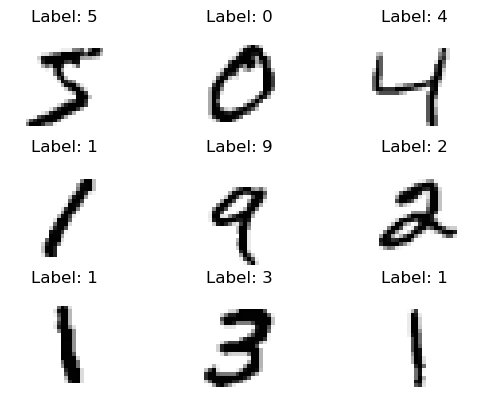

In [119]:
image= mnist.data.to_numpy()

for i in range(1,10):
    plt.subplot(330+i)
    plt.axis("off")
    plt.title("Label: {}".format(y[i-1]))
    plt.imshow((image[i-1].reshape(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')



## Creating Train and Test sets

In [63]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [64]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

In [65]:
y[0], type(y[0])

('5', str)

In [66]:
y = y.astype(np.uint8)
y[0], type(y[0])

(5, numpy.uint8)

You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [67]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuf‐
fling the dataset ensures that this won’t happen.

# Training a binary classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:

In [69]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradi‐ ent Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. Let’s cre‐
ate an SGDClassifier and train it on the whole training set:

In [70]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you
should set the random_state parameter.

Now we can use it to detect images of the number 5:

In [94]:
sgd_clf.predict(X_train)

array([ True, False, False, ...,  True, False, False])

## Performance measures

### Measuring Accuracy Using Cross-Validation

In [97]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [98]:
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None): 
            return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [99]:
never_5_clf = Never5Classifier()

In [100]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

### Confusion Matrix

In [101]:
from sklearn.model_selection import cross_val_predict

In [102]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predic‐ tions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model
that never saw the data during training).

In [105]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column repre‐ sents a predicted class. 

The first row of this matrix considers non-5 images (the nega‐ tive class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s (false negatives), while the remaining 4,096 were correctly classi‐ fied as 5s (true positives). A perfect classifier would have only true positives and true
negatives.

### Precision and Recall

In [108]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred) 

(0.8370879772350012, 0.6511713705958311)

In [109]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [110]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [112]:
from sklearn.metrics import precision_recall_curve 
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

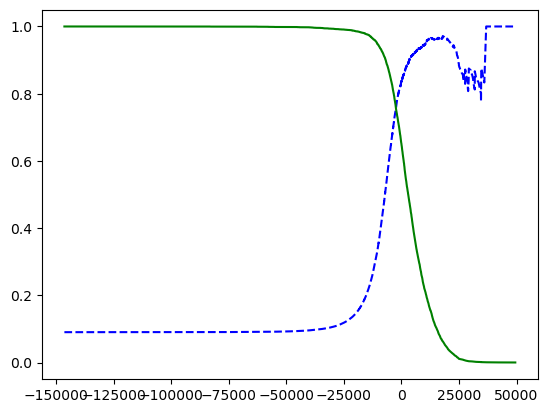

In [114]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.show()

### ROC curve

In [115]:
from sklearn.metrics import roc_curve 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

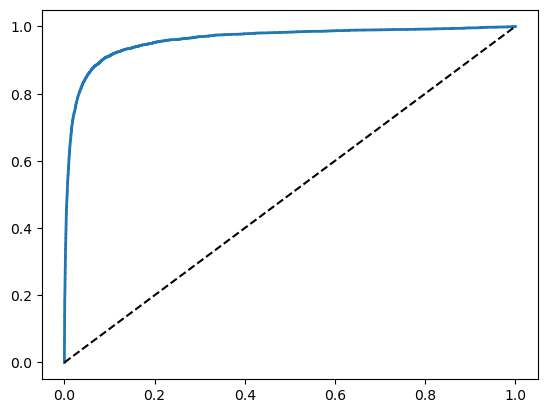

In [117]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal 
    # Add axis labels and grid
    
plot_roc_curve(fpr, tpr)
plt.show()